## Librerías

In [ ]:
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
import os
from dotenv import load_dotenv
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt



## Variables de entorno

In [ ]:

load_dotenv(dotenv_path="/home/jovyan/work/.env")

PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DB = os.getenv("PG_DB")
PG_USER = os.getenv("PG_USER")
PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_SCHEMA_RAW = os.getenv("PG_SCHEMA_RAW")
PG_SCHEMA_ANALYTICS = os.getenv("PG_SCHEMA_ANALYTICS")



## Spark Session

In [ ]:
spark = SparkSession.builder \
    .appName("IngestaParquetPostgres") \
    .config("spark.jars.packages", "org.postgresql:postgresql:42.2.18") \
    .getOrCreate()

pgOptions = {
    "url": f"jdbc:postgresql://{os.getenv('PG_HOST', 'postgres-warehouse')}:{os.getenv('PG_PORT', '5432')}/{os.getenv('PG_DB', 'warehouse_db')}",
    "user": os.getenv("PG_USER", "postgres"),
    "password": os.getenv("PG_PASSWORD", "postgres"),
    "driver": "org.postgresql.Driver"
}

## Columnas a extraer del OBT

In [ ]:
cols_keep = [
    '"PICKUP_HOUR"',
    '"DAY_OF_WEEK"', '"MONTH"', '"YEAR"',
    '"PU_LOCATION_ID"', '"PU_ZONE"', '"PU_BOROUGH"', "'DO_ZONE'",
    '"VENDOR_ID"',
    '"RATE_CODE_ID"','"TRIP_TYPE"',
    '"PASSENGER_COUNT"', '"TRIP_DISTANCE"',
    '"TOTAL_AMOUNT"',
    '"SOURCE_SERVICE"'
]

## Cargar muestras estratificadas

In [ ]:
def load_sample(service, year, n=1000):
    query = f"""
        (
            SELECT *
            FROM (
                SELECT
                    {', '.join(cols_keep)},
                    ROW_NUMBER() OVER (
                        PARTITION BY "PICKUP_HOUR", "DAY_OF_WEEK", "MONTH"
                        ORDER BY RANDOM()
                    ) AS rn
                FROM analytics.obt_trips
                WHERE "SERVICE_TYPE" = '{service}'
                  AND "YEAR" = {year}
            ) AS base
            WHERE rn <= {n}
        ) AS t
    """
    return spark.read.jdbc(url=pgOptions["url"], table=query, properties=pgOptions)


Creando DataFrames de entrenamiento, validación y prueba...
Creando 2022
Creando 2023
Creando 2024
Creando 2025
DataFrames cargados desde Postgres: 


## Crear DataFrames  de entrenamiento, validación y prueba

In [ ]:
print("Creando DataFrames de entrenamiento, validación y prueba...")
print("Creando 2022")
# 2022
df_2022_yellow = load_sample("yellow", 2022, n=200)
df_2022_green  = load_sample("green", 2022, n=200)
df_2022 = df_2022_yellow.union(df_2022_green)
print("Creando 2023")

# 2023
df_2023_yellow = load_sample("yellow", 2023, n=200)
df_2023_green  = load_sample("green", 2023, n=200)
df_2023 = df_2023_yellow.union(df_2023_green)

# Unir ambos años para train
df_train = df_2022.union(df_2023)
print("Creando 2024")

# 2024 validation
df_2024_yellow = load_sample("yellow", 2024, n=200)
df_2024_green  = load_sample("green", 2024, n=200)
df_val = df_2024_yellow.union(df_2024_green)
print("Creando 2025")

# 2025 test
df_2025_yellow = load_sample("yellow", 2025, n=200)
df_2025_green  = load_sample("green", 2025, n=200)
df_test = df_2025_yellow.union(df_2025_green)

print("DataFrames cargados desde Postgres: ")


## Conversión a pandas

In [ ]:
# unir todos los datos para visualizar 2022-2025
print("Haciendo df_train toPandas()...")
df_train = df_train.toPandas()

Haciendo df_train toPandas()...


In [ ]:
print("Haciendo df_val toPandas()...")
df_val = df_val.toPandas()

Haciendo df_val toPandas()...


In [ ]:

print("Haciendo df_test toPandas()...")
df_test = df_test.toPandas()

Haciendo df_test toPandas()...


## Tablas para ver la estratificación

In [ ]:
df_test.groupby(['PICKUP_HOUR', 'MONTH', 'DAY_OF_WEEK', 'SOURCE_SERVICE']).size().reset_index(name='counts')

,PICKUP_HOUR,MONTH,DAY_OF_WEEK,SOURCE_SERVICE,counts
0,0.0,1.0,0.0,green,32
1,0.0,1.0,0.0,yellow,200
2,0.0,1.0,1.0,green,35
3,0.0,1.0,1.0,yellow,200
4,0.0,1.0,2.0,green,31
...,...,...,...,...,...
2690,23.0,8.0,4.0,yellow,200
2691,23.0,8.0,5.0,green,102
2692,23.0,8.0,5.0,yellow,200
2693,23.0,8.0,6.0,green,124


In [ ]:
# shape de todos los dataframes
print("Shapes de los DataFrames:")
print("df_train:", df_train.shape)
print("df_val:", df_val.shape)
print("df_test:", df_test.shape)
print("Conteo por hora y mes en df_train:")

Shapes de los DataFrames:
df_train: (1262446, 16)
df_val: (623503, 16)
df_test: (483106, 16)
Conteo por hora y mes en df_train:


PICKUP_HOUR  MONTH  DAY_OF_WEEK
0.0          1.0    0.0            232
                    1.0            235
                    2.0            231
                    3.0            258
                    4.0            239
                                  ... 
23.0         8.0    2.0            218
                    3.0            210
                    4.0            237
                    5.0            302
                    6.0            324
Length: 1351, dtype: int64

In [33]:
print("conteo de servicio en df_train:")
print(df_train['YEAR'].value_counts())
print(df_train['SOURCE_SERVICE'].value_counts())

conteo de servicio en df_train:
YEAR
2023.0    631314
2022.0    631132
Name: count, dtype: int64
SOURCE_SERVICE
yellow    806400
green     456046
Name: count, dtype: int64


## Guardar como parquet

In [37]:
#guardar dataframe df_all como parquet
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)
df_all.to_parquet(path="/home/jovyan/work/obt_trips_2022_2025.parquet", index=False)
print("DataFrame guardado como obt_trips_2022_2025.parquet")

DataFrame guardado como obt_trips_2022_2025.parquet


## Ver las columnas

In [ ]:
df_all = pd.read_parquet("obt_trips_2022_2025.parquet")
df_all.head()
df_all.columns

Index(['PICKUP_HOUR', 'DAY_OF_WEEK', 'MONTH', 'YEAR', 'PU_LOCATION_ID',
       'PU_ZONE', 'PU_BOROUGH', '?column?', 'VENDOR_ID', 'RATE_CODE_ID',
       'TRIP_TYPE', 'PASSENGER_COUNT', 'TRIP_DISTANCE', 'TOTAL_AMOUNT',
       'SOURCE_SERVICE', 'rn'],
      dtype='object')

## Normalizar nombres y dropear columnas no útiles

In [17]:
# cambiar el nombre de la columna 'VENDOR_ID' a 'vendor_name'
df_all = df_all.rename(columns={'VENDOR_ID': 'vendor_name'})
df_all = df_all.rename(columns={'PASSENGER_COUNT': 'passenger_count'})
df_all = df_all.rename(columns={'TRIP_DISTANCE': 'trip_distance'})
df_all = df_all.rename(columns={'RATE_CODE_ID': 'rate_code_desc'})
df_all = df_all.rename(columns={'TOTAL_AMOUNT': 'total_amount'})
df_all = df_all.rename(columns={'SOURCE_SERVICE': 'service_type'})
df_all = df_all.rename(columns={'DAY_OF_WEEK': 'pickup_dow'})
df_all = df_all.rename(columns={'MONTH': 'pickup_month'})
df_all = df_all.rename(columns={'YEAR': 'pickup_year'})
df_all = df_all.rename(columns={'PICKUP_HOUR': 'pickup_hour'})
df_all = df_all.rename(columns={'PU_BOROUGH': 'pickup_borough'})

# Dropear el resto de columnas que no se van a usar
cols_to_drop = ['PU_LOCATION_ID', 'PU_ZONE', '?column?', 'rn' ,'TRIP_TYPE']
df_all = df_all.drop(columns=cols_to_drop)
df_all.head()

,pickup_hour,pickup_dow,pickup_month,pickup_year,pickup_borough,vendor_name,rate_code_desc,passenger_count,trip_distance,total_amount,service_type
0,0.0,0.0,1.0,2022.0,Manhattan,2,1.0,2.0,5.25,20.80,yellow
1,0.0,0.0,1.0,2022.0,Manhattan,1,1.0,2.0,1.00,8.30,yellow
2,0.0,0.0,1.0,2022.0,Manhattan,2,1.0,1.0,1.29,12.25,yellow
3,0.0,0.0,1.0,2022.0,Manhattan,1,1.0,1.0,3.20,19.55,yellow
4,0.0,0.0,1.0,2022.0,Manhattan,1,1.0,1.0,5.90,24.30,yellow


## Crear nuevas columnas

In [ ]:
# 
df_all['is_weekend'] = df_all['pickup_dow'].apply(lambda x: 1 if x in [0, 6] else 0)
df_all['is_rush_hour'] = df_all['pickup_hour'].apply(lambda x: 1 if x in [16, 17, 18, 19, 20] else 0)
df_all.head()

# guardar df_all modificado como parquet
df_all.to_parquet(path="obt_trips_2022_2025_mod.parquet", index=False)

## Gráficas antes de la limpieza

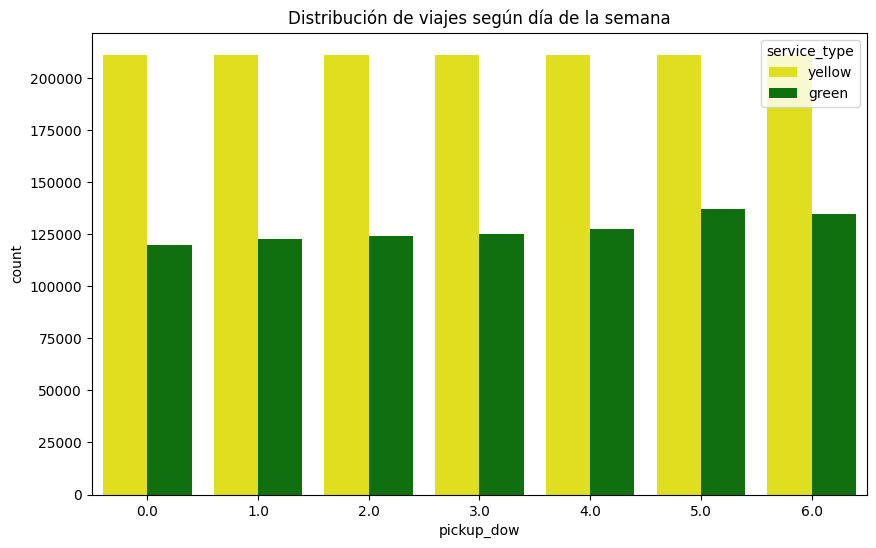

In [36]:
# ver la distribucion de viajes segun dia de la semana
plt.figure(figsize=(10, 6))
palette = {'green': 'green', 'yellow': 'yellow'}
sns.countplot(data=df_all, x='pickup_dow', hue='service_type', palette=palette)
plt.title('Distribución de viajes según día de la semana')
plt.show()

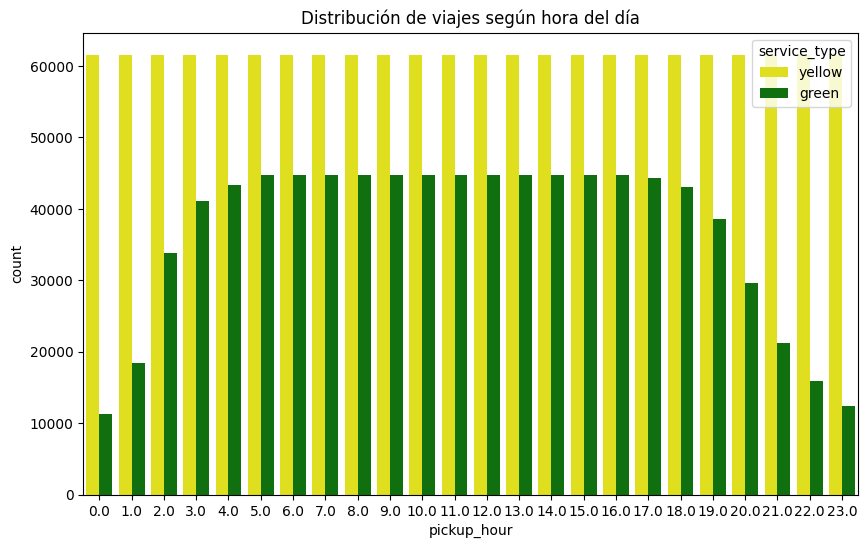

In [35]:
# ver distribucion de viajes segun hora del dia
plt.figure(figsize=(10, 6))
# poner una barra verde para green y amarilla para yellow
palette = {'green': 'green', 'yellow': 'yellow'}
sns.countplot(data=df_all, x='pickup_hour', hue='service_type', palette=palette)
plt.title('Distribución de viajes según hora del día')
plt.show()

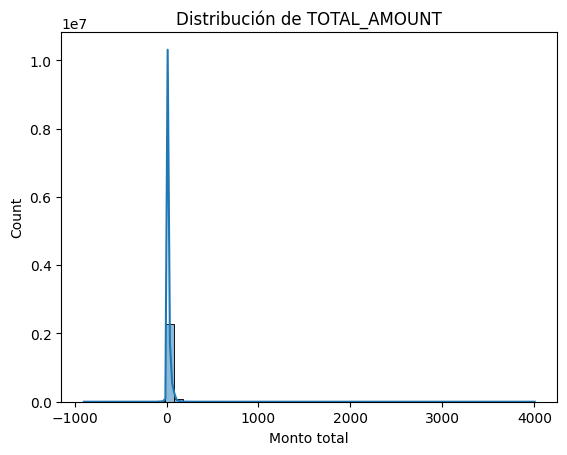

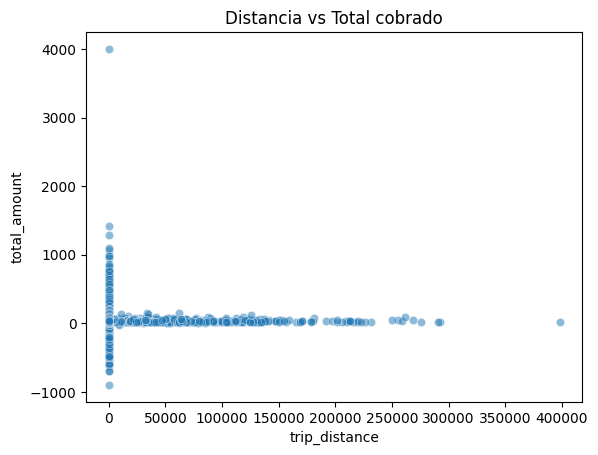

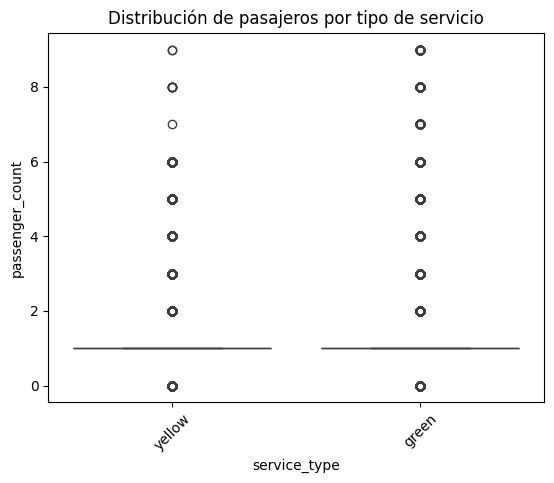

In [25]:
sns.histplot(df_all["total_amount"], bins=50, kde=True)
plt.title("Distribución de TOTAL_AMOUNT")
plt.xlabel("Monto total")
plt.show()

sns.scatterplot(data=df_all, x="trip_distance", y="total_amount", alpha=0.5)
plt.title("Distancia vs Total cobrado")
plt.show()

sns.boxplot(data=df_all, x="service_type", y="passenger_count")
plt.title("Distribución de pasajeros por tipo de servicio")
plt.xticks(rotation=45)
plt.show()

# Limpieza

In [ ]:

# Eliminar filas con pasajeros cero o negativos o mayor a 6

def clean_taxi_data_iqr(df, factor=1.5):
    """
    Limpia datos usando el método IQR para detectar outliers
    factor: multiplicador del IQR (1.5 es estándar,3 ser más conservador)
    max_price_per_mile: umbral máximo de precio por milla para eliminar outliers
    min_price_per_mile: umbral mínimo de precio por milla para eliminar outliers
    """
    df_clean = df.copy()
    df_clean = df_clean[(df_clean["passenger_count"] > 0) & (df_clean["passenger_count"] <= 6)] 

    # Primero eliminar valores imposibles
    df_clean = df_clean[(df_clean['trip_distance'] > 0) & 
                        (df_clean['total_amount'] > 0)]
    
    # Limipar trip distance usando IQR
    Q1 = df_clean['trip_distance'].quantile(0.25)
    Q3 = df_clean['trip_distance'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    df_clean = df_clean[(df_clean['trip_distance'] >= lower_bound) & (df_clean['trip_distance'] <= upper_bound)]

    # Limpiar total_amount usando IQR
    Q1 = df_clean['total_amount'].quantile(0.25)
    Q3 = df_clean['total_amount'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    df_clean = df_clean[(df_clean['total_amount'] >= lower_bound) & (df_clean['total_amount'] <= upper_bound)]
    
    return df_clean

df_all_clean = clean_taxi_data_iqr(df_all, factor=3)


## Graficas después de la limpieza

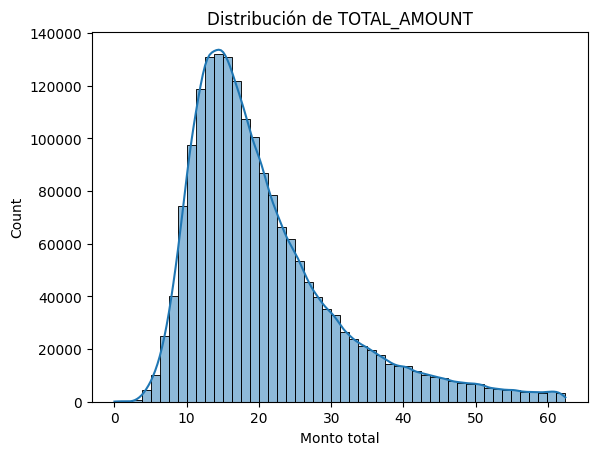

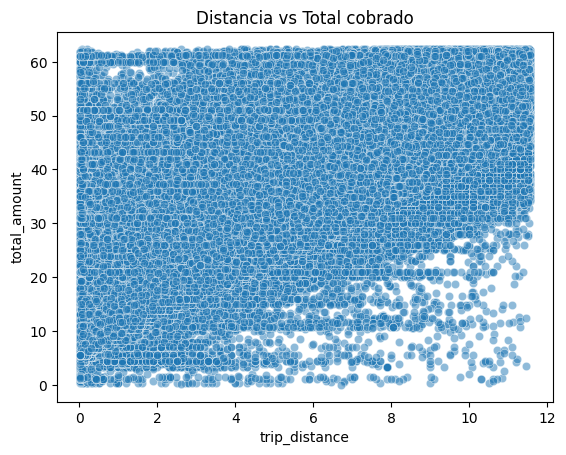

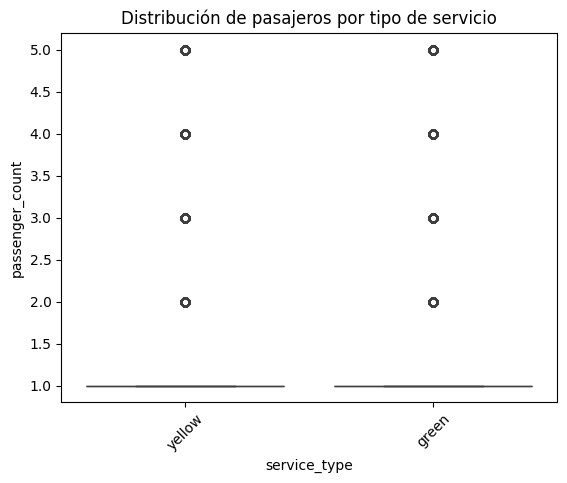

In [32]:
# graficar nuevamente
sns.histplot(df_all_clean["total_amount"], bins=50, kde=True)
plt.title("Distribución de TOTAL_AMOUNT")
plt.xlabel("Monto total")
plt.show()

sns.scatterplot(data=df_all_clean, x="trip_distance", y="total_amount", alpha=0.5)
plt.title("Distancia vs Total cobrado")
plt.show()

sns.boxplot(data=df_all_clean, x="service_type", y="passenger_count")
plt.title("Distribución de pasajeros por tipo de servicio")
plt.xticks(rotation=45)
plt.show()

In [34]:
# guardar df_all_clean como parquet
df_all_clean.to_parquet(path="obt_trips_2022_2025_clean.parquet", index=False)